In [1]:
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.frame import read_frame
from pycbc.filter import highpass, resample_to_delta_t
from astropy.utils.data import download_file
from pycbc.inference import models, sampler
from pycbc.distributions import Uniform, JointDistribution, SinAngle, UniformSky
import numpy
import numpy as np
import h5py
from pycbc.types.frequencyseries import FrequencySeries
from pycbc.detector import Detector
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from pycbc.psd.read import from_txt
from pycbc.psd.read import from_numpy_arrays
from pycbc.types.timeseries import TimeSeries

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
import h5py
from pycbc.waveform import get_td_waveform

parameters = {
    "mass1": "mass1",
    "mass2": "mass2",
    "spin1x": "spin1x",
    "spin1y": "spin1y",
    "spin1z": "spin1z",
    "spin2x": "spin2x",
    "spin2y": "spin2y",
    "spin2z": "spin2z",
    "coa_phase": "coa_phase",
    "inclination": "inclination",
    "distance": "distance",
    "ra": "ra",
    "dec": "dec",
    "polarization": "polarization"
}

parameters2 = {
    "approximant": "IMRPhenomXPHM",
    "delta_t": 1.0/4096,
    "f_lower": 25
}

data = h5py.File('./Phys607_project3/src/data/parameter.h5', 'r')
data_dic = {key: data[dataset_key][:][0] for key, dataset_key in parameters.items()}

inp = {**data_dic, **parameters2}

hp, hc = get_td_waveform(**inp)


In [3]:
inp

{'mass1': 60.22234585403269,
 'mass2': 57.169482517199846,
 'spin1x': -0.2900329586425194,
 'spin1y': -0.08403156551895755,
 'spin1z': 0.04665359681814268,
 'spin2x': -0.18902220102218603,
 'spin2y': 0.07817423823443369,
 'spin2z': -0.25795176714346885,
 'coa_phase': 2.4092341172487513,
 'inclination': 2.7579985692108107,
 'distance': 44168.47968834049,
 'ra': 3.3231447888333756,
 'dec': 0.6229703235736507,
 'polarization': 3.5691292400886723,
 'approximant': 'IMRPhenomXPHM',
 'delta_t': 0.000244140625,
 'f_lower': 25}

In [4]:
variables = ['distance']

In [5]:
for key in variables:
    del inp[key]

In [6]:
variables.append('tc')

In [7]:
static = inp

In [8]:
dim = hp.shape[0]

In [9]:
noise = np.random.normal(0, 1, dim)*10**(-24)

In [10]:
noisy_hp = hp + noise

In [11]:
hp.start_time

LIGOTimeGPS(-11, 0)

In [12]:
hp.end_time

LIGOTimeGPS(5, 0)

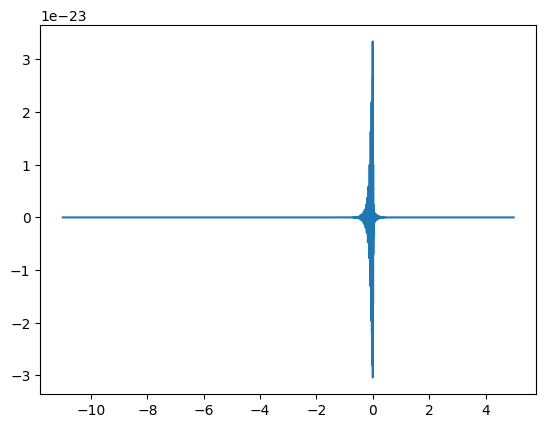

In [13]:
hp.plot()

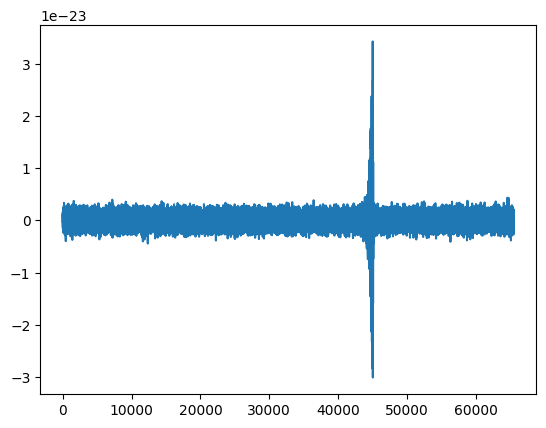

In [14]:
plt.plot(noisy_hp)

In [15]:
ts = TimeSeries(noisy_hp, delta_t=1.0/4096, epoch=0)

In [16]:
ts.start_time

LIGOTimeGPS(0, 0)

In [17]:
ts.end_time

LIGOTimeGPS(16, 0)

In [18]:
noisy_series_hp = ts.to_frequencyseries()  

In [19]:
data_freq = {'H1': noisy_series_hp}

In [20]:
psd = interpolate(ts.psd(16), ts.delta_f)
psd = inverse_spectrum_truncation(psd, int(16 * psd.sample_rate),
                                      trunc_method='hann',
                                      low_frequency_cutoff=25.0)

In [21]:
ts.delta_f

0.0625

([<matplotlib.lines.Line2D at 0x179b30510>],
 [<matplotlib.lines.Line2D at 0x179ed1c90>])

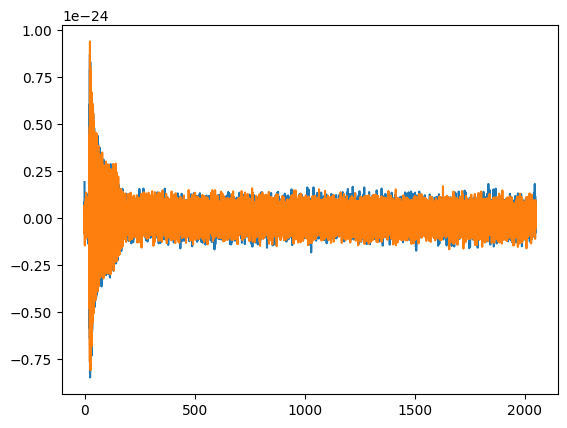

In [22]:
noisy_series_hp.plot()

In [23]:
noisy_series_hp.end_time

LIGOTimeGPS(16, 0)

In [24]:
noisy_series_hp.start_time

LIGOTimeGPS(0, 0)

In [25]:
noisy_series_hp.sample_rate

4096.0

In [26]:
psds = {'H1':psd}

In [27]:
prior = JointDistribution(tuple(variables),
                Uniform(
                    #inclination=(2, numpy.pi),
                    distance=(35000, 48000),
                    tc=(0, 4),
                ),
               # UniformSky(),   # This is a custom distribution which
                                # expects ra / dec and creates a isotropic distribution
        )

In [28]:
import copy
model = models.SingleTemplate(variables, copy.deepcopy(data_freq),
                              low_frequency_cutoff={'H1':25},
                              static_params = static,
                              psds = psds,
                              prior = prior,
                              sample_rate = 4096,
                              )

In [29]:
smpl = sampler.EmceePTSampler(model, 1, 200, nprocesses=8)
_ = smpl.set_p0()

In [30]:
smpl.run_mcmc(500)

In [31]:
lik = smpl.model_stats['loglikelihood']
s = smpl.samples


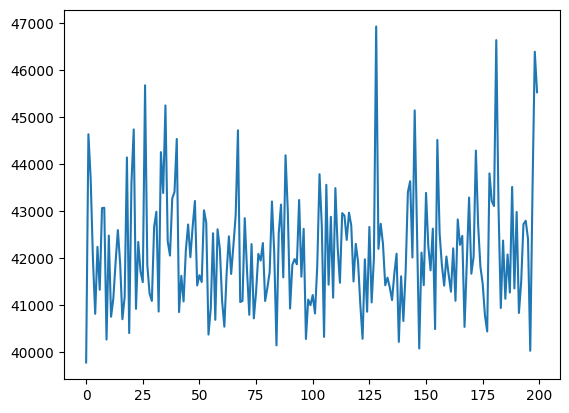

In [32]:
plt.plot(s['distance'][0,:,-1])

(array([13., 35., 46., 44., 33., 13.,  9.,  2.,  2.,  3.]),
 array([39778.49038767, 40493.51565864, 41208.54092961, 41923.56620057,
        42638.59147154, 43353.61674251, 44068.64201348, 44783.66728444,
        45498.69255541, 46213.71782638, 46928.74309734]),
 <BarContainer object of 10 artists>)

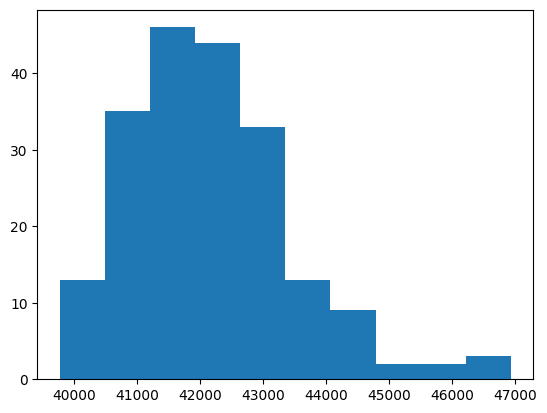

In [33]:
plt.hist(s['distance'][0,:,-1])

In [34]:
smpl = sampler.EmceePTSampler(model, 1, 200, nprocesses=8)
_ = smpl.set_p0()

In [39]:
smpl.run_mcmc(1000)

In [40]:
lik = smpl.model_stats['loglikelihood']
s = smpl.samples


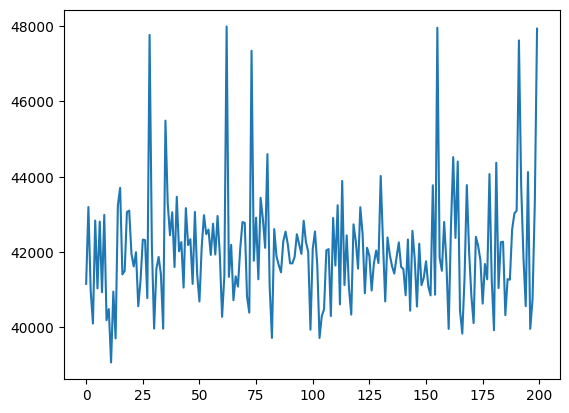

In [41]:
plt.plot(s['distance'][0,:,-1])

(array([ 8., 29., 52., 62., 30., 10.,  2.,  1.,  0.,  6.]),
 array([39066.13193305, 39958.82899011, 40851.52604718, 41744.22310424,
        42636.9201613 , 43529.61721836, 44422.31427542, 45315.01133248,
        46207.70838954, 47100.4054466 , 47993.10250366]),
 <BarContainer object of 10 artists>)

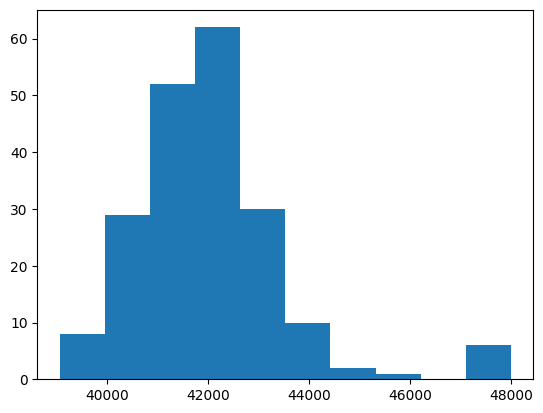

In [42]:
plt.hist(s['distance'][0,:,-1])